# Earth Observation - Land Classification on EuroSAT dataset

* EuroSAT is a large-scale land use and land cover classification dataset derived from multispectral Sentinel-2 satellite imagery covering European continent. 

* EuroSAT is composed of 27,000 georeferenced image patches (64 x 64 pixels) - each patch comprises 13 spectral bands (optical through to shortwave infrared ) resampled to 10m spatila resolution and labelled with one of 10 distinct land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake. 

* Full details including links to journal papers and download instructions may be found here: https://github.com/phelber/eurosat.

![alt text](https://github.com/phelber/EuroSAT/blob/master/eurosat_overview_small.jpg?raw=true)

##  1. Setup Notebook Environment

### 1.1 Import all required packages.

In [33]:
import os
import ssl
import torch
import random
import numpy as np
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import EuroSAT
from torch.utils.tensorboard.writer import SummaryWriter
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingWarmRestarts
from avalanche.benchmarks.datasets import default_dataset_location

### 1.2 Configure settings for the corresponding optimizers and schedulers.

In [34]:
teacher_path = './teacher'
pretrained_student_path = './pretrained_student'
student_path = './student'
small_path = './small'

use_AdamW = True # Flag utilized for switching between AdamW and SGD optimizer.

if use_AdamW:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':20,
            
            # Settings for the optimizer AdamW
            'lr':5e-4, # learning rate
            'weight_decay':5e-4,

            # Settings for the lr_scheduler CosineAnnealingWarmRestarts
            't_0':5, # Number of iterations for the first restart.
            'eta_min':1e-5, # Minimum learning rate
          }
else:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':100,

            # Settings for the optimizer SGD
            'lr':1e-4, # learning rate
            'weight_decay':5e-4,  
            'momentum':0.9,

            # Settings for the lr_scheduler MultiStepLR
            'milestones':[50,75,90], # List of epoch indices.
            'gamma':0.2, # Multiplicative factor of learning rate decay.
          }

### 1.3 Define a function to set a random seed for reproducibility assurance:
* Manage sources of randomness that may lead to varying behaviors in multiple executions of your application.

In [35]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 

set_random_seed(seed=config['seed'])

### 1.4 Tracks the active GPU and allocates all new CUDA tensors on that device by default.

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 2. Data Preparation:

### 2.1 Preparing the dataset:

In [37]:
# Transform pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Dataset download
ssl._create_default_https_context = ssl._create_unverified_context # Turn off the ssl verification.
dataset_path = default_dataset_location("eurosat")
dataset = EuroSAT(root=dataset_path, transform=transform, download=True)

# Train/Test split
n = int(len(dataset) * (1 - config['train_test_split']))
eurosat_train, eurosat_test = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

### 2.2 Visualize Training Data

Image 20952 's label : 6 PermanentCrop


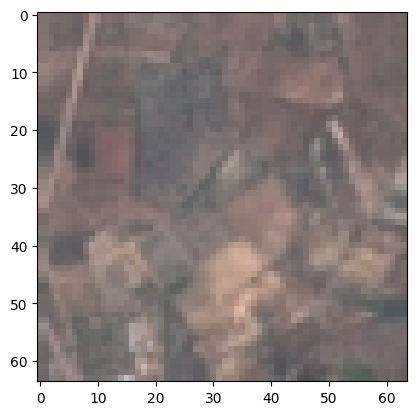

In [38]:
# Randomly select an image from the Training Data for visualization and print its corresponding label.
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
random_index = random.randrange(len(eurosat_train)) # random select an index
random_image = eurosat_train[random_index][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image", random_index, "'s label :", eurosat_train[random_index][1], classes[eurosat_train[random_index][1]])
plt.imshow(random_image)

### 2.3 Instantiate PyTorch data loader that feeds the image tensors to our neural network

In [39]:
# Tr/Val split
n = int(len(eurosat_train) * config['tr_val_split'])
eurosat_tr, eurosat_val = torch.utils.data.random_split(eurosat_train, [n, len(eurosat_train) - n])

# instantiate data loaders
train_dataloader = torch.utils.data.DataLoader(eurosat_tr, batch_size=config['mini_batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(eurosat_val, batch_size=config['mini_batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(eurosat_test, batch_size=config['mini_batch_size'], shuffle=True)

## 3. Model Training

### 3.1 Create a ResNet-50 model using torchvision


In [40]:
num_classes = 10
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
teacher_model = models.resnet50(weights='DEFAULT')
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
teacher_model.to(device)

pretrained_student_model = models.resnet34(weights="DEFAULT")
pretrained_student_model.fc= nn.Linear(pretrained_student_model.fc.in_features, num_classes)
pretrained_student_model.to(device)

student_model = models.resnet34()
student_model.fc= nn.Linear(student_model.fc.in_features, num_classes)
student_model.to(device)

small_model = models.resnet34(weights="DEFAULT")
small_model.fc= nn.Linear(small_model.fc.in_features, num_classes)
small_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3.2 Define criterion

In [41]:
criterion = nn.CrossEntropyLoss()

### 3.3 Define the Training Loop
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

* Gets a batch of training data from the DataLoader

* Zeros the optimizer’s gradients

* Performs an inference - that is, gets predictions from the model for an input batch

* Calculates the loss for that set of predictions vs. the labels on the dataset

* Calculates the backward gradients over the learning weights

* Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

* Finally, it reports the averaged epoch loss for comparison with a validation run

In [42]:
def train_one_epoch(model,optimizer,epoch_index, tb_writer):
    running_loss = 0.
    train_loss = 0.
    train_acc = 0.
    num_correct = 0
    num_samples = 0

    for _, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device))

        loss = criterion(outputs, labels.to(device))
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predictions = outputs.max(dim=-1)
        num_correct += (predictions == labels.to(device)).sum()
        num_samples += predictions.size(0)
        
    train_loss = running_loss/len(train_dataloader)
    train_acc = float(num_correct)/float(num_samples)

    return train_loss, train_acc

def train(model,model_path):

    path=model_path[1:]

    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    timestamp = datetime.now().strftime('%Y%m%d')
    writer = SummaryWriter('./{}{}'.format(timestamp,path))
    epoch_number = 0
    tr_acc = 0.0
    best_vloss = 1_000_000.

    for epoch in range(config['epochs']):
        print('============= EPOCH {} ============='.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss, tr_acc = train_one_epoch(model,optimizer,epoch_number, writer)

        running_vloss = 0.0
        val_acc = 0.0
        num_vcorrect = 0
        num_vsamples = 0

        # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs.to(device))
                vloss = criterion(voutputs, vlabels.to(device))
                running_vloss += vloss
                _, vpredictions = voutputs.max(dim=-1)
                num_vcorrect += (vpredictions == vlabels.to(device)).sum()
                num_vsamples += vpredictions.size(0)

        avg_vloss = running_vloss / len(val_dataloader)
        val_acc = float(num_vcorrect)/float(num_vsamples)
        print('LOSS : train {} | valid {}'.format(round(avg_loss, 4), round(avg_vloss.item(), 4)))
        print('ACC  : train {}% | valid {}%'.format(round(tr_acc*100, 2), round(val_acc*100),2))

        # Log the running loss averaged per epoch for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.add_scalars('Training vs. Validation Accuracy',
                        { 'Training' : tr_acc, 'Validation' : val_acc },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), model_path)

        epoch_number += 1


#### 3.4 Train Teacher and Student
* we also train the student to its performance without any specific process

In [21]:
print("--> Training Teacher Model <--")
train(teacher_model,teacher_path)
print("\n--> Training Small Model <--")
train(small_model,small_path)

--> Training Teacher Model <--
============= EPOCH 1 =============


LOSS : train 0.5302 | valid 0.4309
ACC  : train 84.2% | valid 88%
============= EPOCH 2 =============
LOSS : train 0.148 | valid 0.287
ACC  : train 95.47% | valid 91%
============= EPOCH 3 =============
LOSS : train 0.0749 | valid 0.2526
ACC  : train 97.74% | valid 93%
============= EPOCH 4 =============
LOSS : train 0.06 | valid 0.2606
ACC  : train 98.05% | valid 93%
============= EPOCH 5 =============
LOSS : train 0.0623 | valid 0.2287
ACC  : train 98.07% | valid 94%
============= EPOCH 6 =============
LOSS : train 0.0669 | valid 0.2142
ACC  : train 97.84% | valid 94%
============= EPOCH 7 =============
LOSS : train 0.0576 | valid 0.1722
ACC  : train 98.48% | valid 95%
============= EPOCH 8 =============
LOSS : train 0.0382 | valid 0.3495
ACC  : train 98.91% | valid 91%
============= EPOCH 9 =============
LOSS : train 0.045 | valid 0.2911
ACC  : train 98.85% | valid 94%
============= EPOCH 10 =============
LOSS : train 0.0642 | valid 0.237
ACC  : train 98.4% | valid 94%
=============

### 3.5 Define Distillation Training Loop

In [50]:
def train_knowledge_distillation(teacher, student, T, soft_target_loss_weight, ce_loss_weight, device,student_path):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(student.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    teacher.eval()  # Teacher set to evaluation mode

    tr_acc = 0.0
    best_vloss = 1_000_000.

    for epoch in range(config['epochs']):
        student.train() # Student to train mode

        print('============= EPOCH {} ============='.format(epoch + 1))

        running_loss = 0.
        num_correct = 0
        num_samples = 0
        running_vloss = 0.0
        val_acc = 0.0
        num_vcorrect = 0
        num_vsamples = 0

        for _, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predictions = student_logits.max(dim=-1)

            num_correct += (predictions == labels.to(device)).sum()
            num_samples += predictions.size(0)

        avg_loss = running_loss/len(train_dataloader)
        tr_acc = float(num_correct)/float(num_samples)
            # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.

        student.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = student(vinputs.to(device))
                vloss = criterion(voutputs, vlabels.to(device))
                running_vloss += vloss
                _, vpredictions = voutputs.max(dim=-1)
                num_vcorrect += (vpredictions == vlabels.to(device)).sum()
                num_vsamples += vpredictions.size(0)

        avg_vloss = running_vloss / len(val_dataloader)
        val_acc = float(num_vcorrect)/float(num_vsamples)
        print('LOSS : train {} | valid {}'.format(round(avg_loss, 4), round(avg_vloss.item(), 4)))
        print('ACC  : train {}% | valid {}%'.format(round(tr_acc*100, 2), round(val_acc*100),2))

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(student.state_dict(), student_path)


### 3.6 Student training
*  train of two students, one with no pretrained weight

In [51]:

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=teacher_model, student=pretrained_student_model, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device,student_path=pretrained_student_path)
train_knowledge_distillation(teacher=teacher_model, student=student_model, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device,student_path=student_path)

============= EPOCH 1 =============
LOSS : train 0.7094 | valid 0.7052
ACC  : train 85.6% | valid 83%
============= EPOCH 2 =============
LOSS : train 0.5286 | valid 0.5129
ACC  : train 94.38% | valid 89%
============= EPOCH 3 =============
LOSS : train 0.4869 | valid 0.6604
ACC  : train 95.99% | valid 83%
============= EPOCH 4 =============
LOSS : train 0.4833 | valid 0.4782
ACC  : train 96.26% | valid 91%
============= EPOCH 5 =============
LOSS : train 0.4606 | valid 0.4413
ACC  : train 97.74% | valid 92%
============= EPOCH 6 =============
LOSS : train 0.449 | valid 0.4508
ACC  : train 97.92% | valid 91%
============= EPOCH 7 =============
LOSS : train 0.4514 | valid 0.4731
ACC  : train 97.98% | valid 92%
============= EPOCH 8 =============
LOSS : train 0.4504 | valid 0.3965
ACC  : train 98.02% | valid 93%
============= EPOCH 9 =============
LOSS : train 0.4272 | valid 0.4143
ACC  : train 99.03% | valid 93%
============= EPOCH 10 =============
LOSS : train 0.4289 | valid 0.4105
ACC

## 4. Model evaluation on Test Data

### 4.1 Load the models.

In [54]:
teacher_model = models.resnet50(weights='DEFAULT')
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
teacher_model.load_state_dict(torch.load(teacher_path))
teacher_model.to(device)
teacher_model.eval()

pretrained_student_model = models.resnet34(weights="DEFAULT")
pretrained_student_model.fc= nn.Linear(pretrained_student_model.fc.in_features, num_classes)
pretrained_student_model.load_state_dict(torch.load(pretrained_student_path))
pretrained_student_model.to(device)
pretrained_student_model.eval()

student_model = models.resnet34()
student_model.fc= nn.Linear(student_model.fc.in_features, num_classes)
student_model.load_state_dict(torch.load(student_path))
student_model.to(device)
student_model.eval()

small_model = models.resnet34(weights="DEFAULT")
small_model.fc= nn.Linear(small_model.fc.in_features, num_classes)
small_model.load_state_dict(torch.load(small_path))
small_model.to(device)
small_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.2 Define Evaluation Loop

In [55]:
def eval_loop(model):
    running_tloss = 0.
    test_acc = 0.
    num_tcorrect = 0
    num_tsamples = 0
    with torch.no_grad():
        for _, tdata in enumerate(test_dataloader):
            tinputs, tlabels = tdata
            toutputs = model(tinputs.to(device))
            tloss = criterion(toutputs, tlabels.to(device))
            running_tloss += tloss
            _, tpredictions = toutputs.max(dim=-1)
            num_tcorrect += (tpredictions == tlabels.to(device)).sum()
            num_tsamples += tpredictions.size(0)
    avg_tloss = running_tloss/len(test_dataloader)
    test_acc = float(num_tcorrect)/float(num_tsamples)
    return avg_tloss,test_acc

### 5.3 Evaluate the models on the Test Data.

In [57]:
print(f"---> Teacher (ResNet50) <---")
teacher_avg_tloss, teacher_test_acc = eval_loop(teacher_model)
print(f'Loss: {round(teacher_avg_tloss.item(),4)}')
print(f'Accuracy: {round(teacher_test_acc*100,2)}')


print(f"---> ResNet34 <---")
print(f"This are the performance of ResNet34 with no distillation process")
print(f"The students have the same model")
small_model_avg_tloss, small_model_test_acc = eval_loop(small_model) 
print(f'Loss: {round(small_model_avg_tloss.item(),4)}')
print(f'Accuracy: {round(small_model_test_acc*100,2)}')


print(f"---> Student <---")
teacher_avg_tloss, teacher_test_acc = eval_loop(student_model)
print(f'Loss: {round(teacher_avg_tloss.item(),4)}')
print(f'Accuracy: {round(teacher_test_acc*100,2)}')


print(f"---> Pretrained Student <---")
teacher_avg_tloss, teacher_test_acc = eval_loop(pretrained_student_model)
print(f'Loss: {round(teacher_avg_tloss.item(),4)}')
print(f'Accuracy: {round(teacher_test_acc*100,2)}')

---> Teacher (ResNet50) <---
Loss: 0.152
Accuracy: 95.07
---> ResNet34 <---
This are the performance of ResNet34 with no distillation process
The students have the same model
Loss: 0.2031
Accuracy: 93.67
---> Student <---
Loss: 0.7089
Accuracy: 80.96
---> Pretrained Student <---
Loss: 0.3558
Accuracy: 94.67
